## VAE 变分自编码器训练实现

In [1]:
import torch 
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
from torchvision import datasets, transforms
import matplotlib.pyplot as plt

In [2]:
## set params
input_dim = 784
hidden_dim = 200
latent_dim = 20
epochs = 30
learning_rate = 3e-4
batch_size = 32

In [3]:
## VAE encoder
class Encoder(nn.Module):
    def __init__(self, input_dim, hidden_dim, latent_dim):
        super().__init__()
        self.linear = nn.Linear(input_dim, hidden_dim)
        self.linear_mu = nn.Linear(hidden_dim, latent_dim)
        self.linear_logvar = nn.Linear(hidden_dim, latent_dim)
    
    def forward(self, x):
        h = self.linear(x)
        h = F.relu(h)
        mu = self.linear_mu(h)
        logvar = self.linear_logvar(h)
        sigma = torch.exp(0.5 ** logvar)
        return mu, sigma

In [4]:
## VAE decoder
class Decoder(nn.Module):
    def __init__(self, latent_dim, hidden_dim, output_dim):
        super().__init__()
        self.linear1 = nn.Linear(latent_dim, hidden_dim)
        self.linear2 = nn.Linear(hidden_dim, output_dim)
    
    def forward(self, z):
        h = self.linear1(z)
        h = F.relu(h)
        h = self.linear2(h)
        x_hat = F.sigmoid(h)
        return x_hat

In [5]:
## VAE class
def reparameterize(mu, sigma):
    eps = torch.randn_like(sigma)
    return mu + eps * sigma

class VAE(nn.Module):
    def __init__(self, input_dim, hidden_dim, latent_dim):
        super().__init__()
        self.encoder = Encoder(input_dim, hidden_dim, latent_dim)
        self.decoder = Decoder(latent_dim, hidden_dim, input_dim)
    
    def get_loss(self, x):
        mu, sigma = self.encoder(x)
        z = reparameterize(mu, sigma)
        x_hat = self.decoder(z)

        batch_size = len(x)
        L1 = F.mse_loss(x_hat, x, reduction='sum')
        L2 = -torch.sum(1+torch.log(sigma ** 2) - mu ** 2 - sigma ** 2)
        return (L1 + L2) / batch_size

In [6]:
## train
# 1. datasets
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Lambda(torch.flatten)
])

dataset = datasets.MNIST(
    root = "./data",
    train=True,
    download=True,
    transform=transform
)

dataloader = torch.utils.data.DataLoader(
    dataset,
    batch_size=batch_size,
    shuffle=True
)

# 2. model and optimizer
model = VAE(input_dim, hidden_dim, latent_dim)
optimizer = optim.Adam(model.parameters(), lr = learning_rate)
losses = []

# 3. train epoch
for epoch in range(epochs):
    loss_sum = 0.0
    cnt = 0

    for x, label in dataloader:
        optimizer.zero_grad()
        loss = model.get_loss(x)
        loss.backward()
        optimizer.step()

        loss_sum += loss.item()
        cnt += 1

    loss_avg = loss_sum / cnt
    losses.append(loss_avg)
    print(loss_avg)

56.43513506876628
47.485450838216146
46.80411787516276
46.47172985839844
46.21717596638997
46.079893395996095
45.962346700032555
45.833537658691405
45.72226462809245
45.66394424031576
45.53307016601563
45.47367540893555
45.518334547932945
45.45600348714193
45.35259271647136
45.36820243937174
45.285363244628904
45.258782088216144
45.254664929199215
45.23855635579427
45.2091071105957
45.20632395426432
45.12732533976237
45.12707241821289
45.113999607340496
45.03268211669922
45.06562500406901
45.10895390218099
44.99911098022461
45.05478823445638


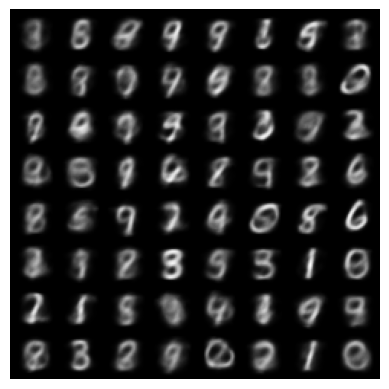

In [7]:
## predict/generate new images
with torch.no_grad():
    sample_size = 64
    z = torch.randn(sample_size, latent_dim)
    x = model.decoder(z)
    generated_images = x.view(sample_size, 1, 28, 28)

grid_img = torchvision.utils.make_grid(
    generated_images,
    nrow = 8,
    padding = 2,
    normalize=True
)

plt.imshow(grid_img.permute(1, 2, 0))
plt.axis('off')
plt.show()